<a href="https://colab.research.google.com/github/MaharshiYeluri01/20-Newsgroups-Ciphertext-Kaggke-Challenge-/blob/master/20NewsgroupsCiphertextChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>20 Newsgroups Ciphertext Challenge</h1>
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. ed some tools for cracking simple ciphers. This kernel explores the data, creates some helpful functionality for all ciphers, and applies them to cracking the first two ciphers.

Each document has been encrypted with up to 4 layered ciphers (ciphers 1, 2, 3, and 4). We've used a difficulty value here to denote which ciphers were used for a particular piece of text.



<h1>Encryptions</h1>
  <p>Generrally There are two types of Encryptions </p>
  <h2>substitution</h2>
  It basically consists of substituting every plaintext character for a different ciphertext character. It differs from the Caesar cipher in that the cipher alphabet is not simply the alphabet shifted, it is completely jumbled.
  
  Keys for the simple substitution cipher usually consist of 126 Ascii (compared to the caeser cipher's single number). 
<h3>Example</h3> 
  
  plain alphabet : abcdefghijklmnopqrstuvwxyz
  
cipher alphabet: phqgiumeaylnofdxjkrcvstzwb

<h2>transposition</h2>

 It is a transposition cipher that follows a simple rule for mixing up the characters in the plaintext to form the ciphertext. 
 
<h3>Example</h3> defend the east wall of the castle

We write it out in a special way on a number of rails (the key here is 3)

d . . . n . . . e . . . t . . . l . . . h . . . s . . .

. e . e . d . h . e . s . w . l . o . t . e . a . t . e

. . f . . . t . . . a . . . a . . . f . . . c . . . l .

The ciphertext is read off along the rows:

dnetlhseedheswloteateftaafcl

### Preliminary Setup
If not being run on a Kaggle kernel, you need to [create an API Token](https://github.com/Kaggle/kaggle-api#api-credentials), upload it, and make sure it is in the directory (usually ~/.kaggle/kaggle.json)

In [0]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 70 Jan 10 09:35 kaggle.json


In [0]:
!kaggle competitions download -c 20-newsgroups-ciphertext-challenge

  0% 0.00/556k [00:00<?, ?B/s]
100% 556k/556k [00:00<00:00, 35.0MB/s]
 56% 9.00M/16.2M [00:00<00:00, 23.9MB/s]
100% 16.2M/16.2M [00:00<00:00, 36.5MB/s]
  0% 0.00/6.98M [00:00<?, ?B/s]
100% 6.98M/6.98M [00:00<00:00, 63.5MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("./test.csv.zip", 'r')
zip_ref.extractall('rawdata')
zip_ref = zipfile.ZipFile("./train.csv.zip", 'r')
zip_ref.extractall('rawdata')
zip_ref.close()

In [0]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from fuzzywuzzy import fuzz, process
import Levenshtein as leven
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import re
import nltk
import warnings
from collections import Counter

import itertools
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from itertools import compress
import collections, itertools
import sklearn.feature_extraction.text as sktext
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from dask import delayed, compute
from dask.diagnostics import ProgressBar
ProgressBar().register()

<h2>Exploratory Data Analysis</h2>

In [0]:
train_df = pd.read_csv('rawdata/train.csv')
test_df =  pd.read_csv('rawdata/test.csv')
test_df['length'] = np.array([len(test_df['ciphertext'].iloc[idx]) for idx in range(len(test_df))],dtype=int)
train_df['length'] = np.array([len(train_df['ciphertext'].iloc[idx]) for idx in range(len(train_df))],dtype=int)

In [0]:
print("Train data")
train_df.tail(5)

Train data


,Id,difficulty,ciphertext,target
39047,ID_5259fc914,2,.eh{[8h}8h{-z8b8z8b8xx~V}$v897Vkz,12
39048,ID_d748052c0,1,"A18t1t0adv10O81""^A1Wa88ads1s120#avtaOv1...",19
39049,ID_5f68231a0,3,"o}8Z?4p}{8.i}u{g$?a8 ,8{7$8.*s?$488U{8j}g8...",3
39050,ID_475b4444b,2,{8OS88A{8h}8{7$8?V{$}{8*$?$V}$[888ISccz8h{87...,6
39051,ID_6a8832e6d,3,*C4$*88pg8i.ugj}[8J??84b$Yg8&$?Z{gk}8${^$...,18


In [0]:
print("Test data")
test_df.tail(5)

Test data


,Id,difficulty,ciphertext,length
91117,ID_0a66f7d5a,1,A1zO#aA1:1s1Wa881'^vt1O1vc--O#os1s120#vs1e...,144
91118,ID_df9a9edc3,3,8^7l8}ZsL8{7$i87UM8v{8PJ8o{8LgNB{h8o*$Z??n87...,300
91119,ID_3d143a90c,4,r88{{u{l*8iy}z?u7Z.48$8i7?m8${iM#s $}m^8l...,300
91120,ID_728c606ae,1,1^cAO#av1Wa8811A#OW1c'1o1d^taOta^T1...,300
91121,ID_2b26ba5e7,1,*#^-G1a88)'O+t^b]^c#A_^-s1>cX_tG1/#da_s1%...,300


Text(0.5,1,'Distribution of calsses over Train data')

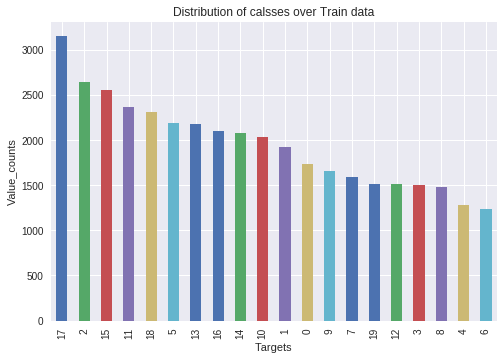

In [0]:
train_df['target'].value_counts().plot(kind='bar')
plt.xlabel('Targets')
plt.ylabel('Value_counts')
plt.title('Distribution of calsses over Train data')

Text(0.5,1,'Distribution of Difficulty over Train data')

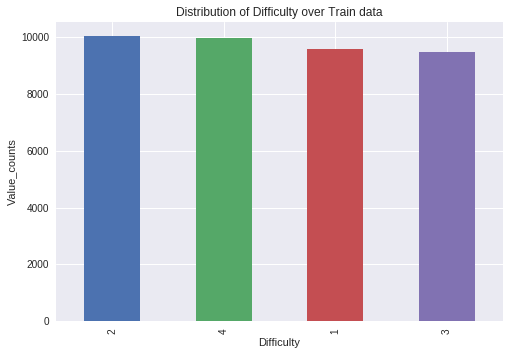

In [0]:

train_df['difficulty'].value_counts().plot(kind='bar')
plt.xlabel('Difficulty')
plt.ylabel('Value_counts')
plt.title('Distribution of Difficulty over Train data')

Text(0.5,1,'Distribution of Difficulty over Test data')

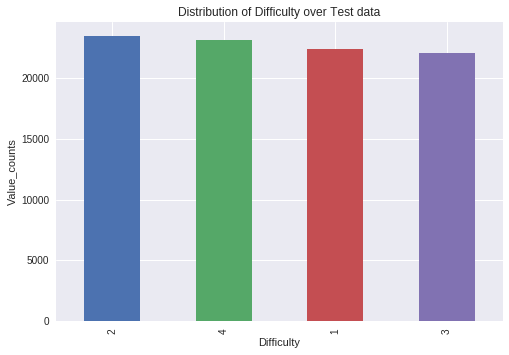

In [0]:

test_df['difficulty'].value_counts().plot(kind='bar')
plt.xlabel('Difficulty')
plt.ylabel('Value_counts')
plt.title('Distribution of Difficulty over Test data')

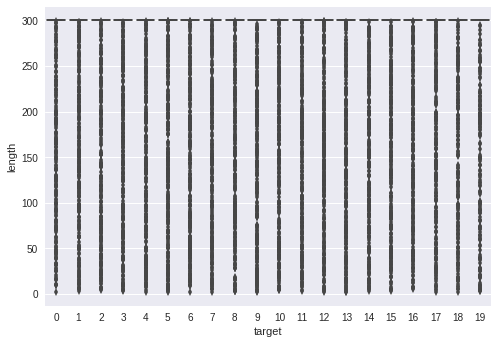

In [0]:
import seaborn as sns
sns.boxplot(train_df['target'],train_df['length'])

In [0]:
def no_of_chars(difficulty):
  
  plain_counts = pd.Series(collections.Counter(itertools.chain.from_iterable(train_df[train_df['difficulty']==difficulty]['ciphertext']))).rename("counts").to_frame() \
    .sort_values("counts", ascending = False)
  plt.figure(figsize=(16,6))
  plain_counts['counts'].plot(kind='bar')
  plt.title("analysis of Chars  for difficulty {}".format(difficulty))
  plt.ylabel('Counts')
  plt.show()

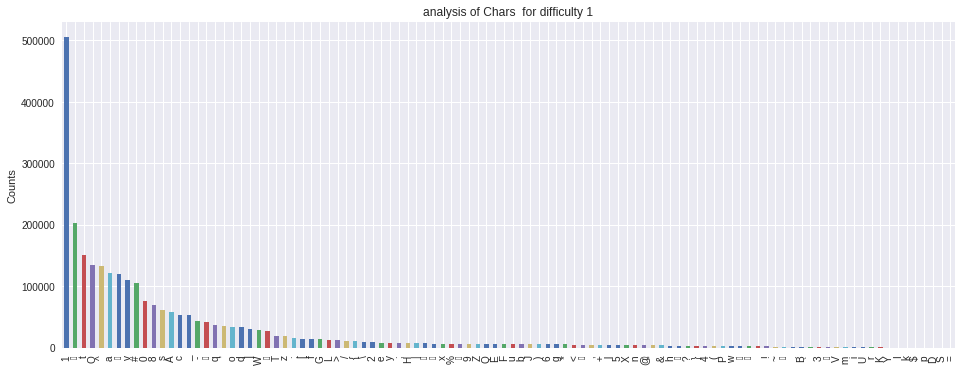

In [0]:
no_of_chars(difficulty=1)

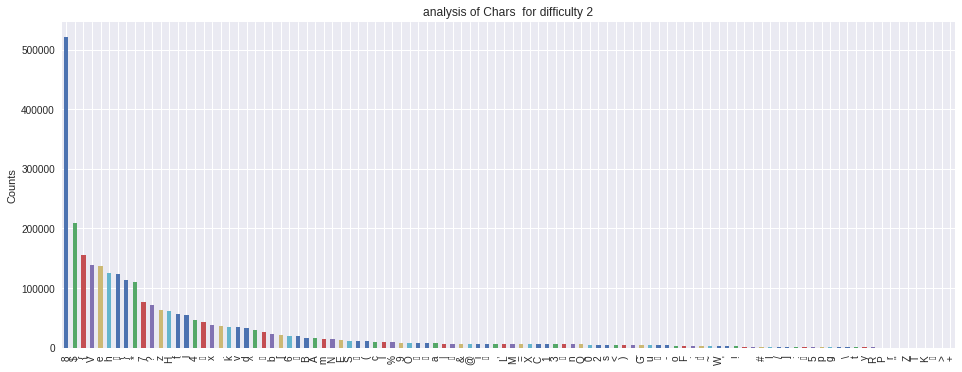

In [0]:
no_of_chars(difficulty=2)

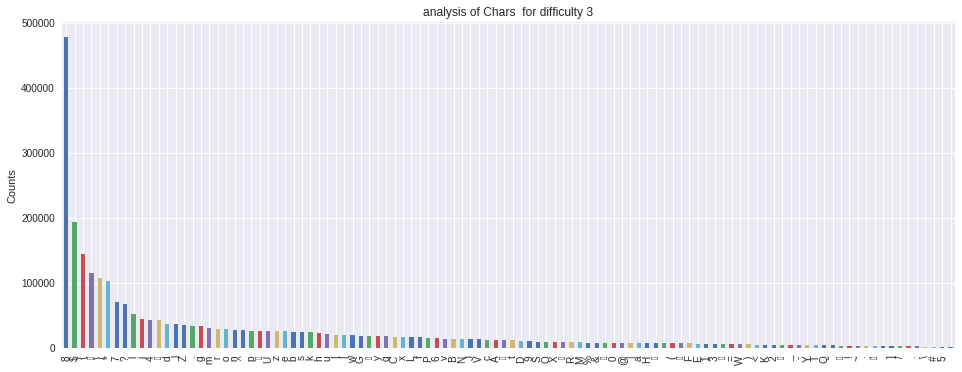

In [0]:
no_of_chars(difficulty=3)

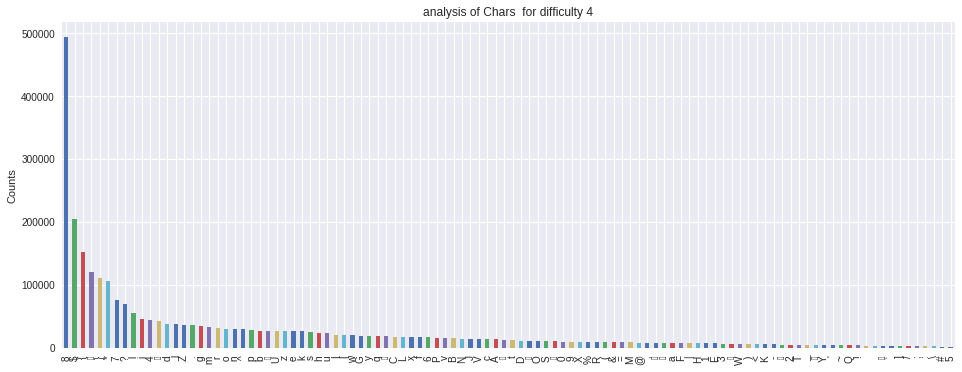

In [0]:
no_of_chars(difficulty=4)

In [0]:
from sklearn.datasets import fetch_20newsgroups
plaintext_data = fetch_20newsgroups(subset='all', download_if_missing=True)
category_names = plaintext_data.target_names

In [0]:

def sourcetransform(textstring):
    return textstring.replace('\r\n','\n').replace('\r','\n').replace('\n','\n ').rstrip(' ')

sourcetext = twenty_databunch.data
for i,textstring in enumerate(sourcetext):
    sourcetext[i] = sourcetransform(textstring)
    
twenty_databunch.data = sourcetext

twenty_datalengths = [len(datastring) for datastring in twenty_databunch.data]

category_names = twenty_databunch.target_names


In [0]:
chunks_plaintext = []
chunks_target = []
chunks_length = []
for i in range(len(twenty_databunch.target)):
    strlength = len(twenty_databunch.data[i])
    if strlength > 300:
        for j in range(strlength // 300):
            chunks_plaintext.append(twenty_databunch.data[i][300*j:300*(j+1)])
            chunks_target.append(twenty_databunch.target[i])
            chunks_length.append(300)
        if strlength%300 > 0:
            chunks_plaintext.append(twenty_databunch.data[i][300*(strlength // 300):(300*(strlength // 300)+strlength%300)])
            chunks_target.append(twenty_databunch.target[i])
            chunks_length.append(strlength%300)
    else:
        chunks_plaintext.append(twenty_databunch.data[i])
        chunks_target.append(twenty_databunch.target[i])
        chunks_length.append(strlength)
        
chunk_df = pd.DataFrame({'plaintext':chunks_plaintext,
                         'length':np.array(chunks_length,dtype=int), 
                         'target':np.array(chunks_target,dtype=int)})
chunk_df['testref'] = np.nan
chunk_df['trainref'] = np.nan

 is is very helpful to have a copy of the data in dictionary form for fuzzy wuzzy lookup

In [0]:
sourcetext_dict = {idx: el for idx, el in enumerate(chunks_plaintext)}
chunk_df.tail()

In [0]:
chunk_df.head()

,length,plaintext,target,testref,trainref
0,300,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,NaN,NaN
1,300,he recent Pens massacre of the Devils. Actuall...,10,NaN,NaN
2,300,s regular season stats. He is also a lot\n fo ...,10,NaN,NaN
3,19,PENS RULE!!!\n \n,10,NaN,NaN
4,300,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,NaN,NaN


<h4>As each difficulty has different legth of documents let us look into the counts per 1m charecters for each level of difficulty</h4>

In [0]:
plain_counts = pd.Series(collections.Counter(itertools.chain.from_iterable(plaintext_data.data))) \
    .rename("counts").to_frame() \
    .sort_values("counts", ascending = False)
plain_counts = 1000000 * plain_counts / plain_counts.sum()
plain_counts = plain_counts.reset_index().rename(columns = {"index":"plain_char"})

diff_counts = []
for i in range(1,5):
    counts = pd.Series(
        collections.Counter(itertools.chain.from_iterable(train_df.query("difficulty == @i")["ciphertext"].values)) + \
        collections.Counter(itertools.chain.from_iterable(test_df.query("difficulty == @i")["ciphertext"].values))
        ).rename("counts/Million").to_frame() \
        .sort_values("counts/Million", ascending = False)
    counts = 1000000 * counts / counts.sum()
    counts = counts.reset_index().rename(columns = {"index":"diff_{}".format(i)})
    diff_counts.append(counts)

pd.concat([plain_counts] + diff_counts, axis = 1).head(20)

,plain_char,counts,diff_1,counts/Million,diff_2,counts/Million,diff_3,counts/Million,diff_4,counts/Million
0,,165064.384460,1,189207.632850,8,186653.120050,8,181524.273903,8,178075.739137
1,e,76404.121344,,76324.791098,$,75554.121129,$,74037.405567,$,73205.998775
2,t,56850.141666,t,56848.251952,{,55948.434335,{,55100.786035,{,54732.324929
3,a,50544.912798,O,50491.551499,V,50050.023467,,43898.609813,,43254.443977
4,o,50309.687605,^,50032.188030,e,49662.492851,},40795.051412,},39623.105140
5,i,46010.203932,a,45860.048537,h,45263.340385,*,38834.514190,*,38238.694320
6,n,45126.701007,,44894.239090,,44646.867946,7,26993.838377,7,27034.715750
7,s,41604.682058,v,41435.079345,},40928.437262,?,25643.026183,?,24947.357193
8,r,39825.516121,#,39559.757198,*,39309.460919,l,19817.712575,l,19514.762010
9,h,28251.929026,0,28531.101031,7,28102.448146,i,16400.932250,i,16376.274720


<h2> Let's Write Some ReUsable Fuctions</h2>

The functions in the code section below may be helpful:
* translating between strings of text and 8-bit ascii representations (`string2ascii` and `ascii2string`)
* calculating vectors where each element is the frequency of character per million characters of text ( `char_per_million`)
* decipher function for a substitution cipher given a mapping between ascii characters (`decipher_subst`)
* trimming a longer text to match a shorter one with the same fuzzy similarity (`trim_matchedsource`)
* matrix of ascii character replacement operations needed for Levenshtein distance (`leven_replace_matrix`)


And for later use:
* calculating vectors where each element is the frequency of word/ngram per million characters of text (`word_per_million` and `ngram_per_million`). We can use these calculate similarity to properties of a source language.text (`similarity_score`)

In [0]:
def string2ascii(textstring):
    return np.array([ord(char) for char in textstring], dtype=np.int8)

def ascii2string(nparray):
    return ''.join(chr(npint) for npint in nparray)

def char_per_million(stringsarray):
    asciicount = np.zeros((128,), dtype=int)
    for k,textdata in enumerate(stringsarray):
        asciicount += np.histogram(string2ascii(textdata),np.arange(129))[0]
    totalchars = np.sum(asciicount)
    return np.multiply(asciicount,np.divide(1000000.0,totalchars))

def decipher_subst(textstring,asciimap):
    inarray = string2ascii(textstring)
    outarray = np.zeros(len(inarray),dtype=np.int8)
    for asciival in asciimap.index:
        outarray[inarray==asciival] = asciimap['decipher'].loc[asciival]
    return ascii2string(outarray)


In [0]:
def leven_replace_matrix(textA,textB):
    # initialize output matrix
    asciiswitchmat = np.zeros([128,128],dtype=int)
    # calculate edits for Levenshtein distance
    lops = leven.editops(textA,textB)
    # count the character replacements needed
    replacetf = [editop[0] is 'replace' for editop in lops]
    replacerefA =  np.array([editop[1] for editop in lops],dtype=np.int8)
    replacerefB =  np.array([editop[2] for editop in lops],dtype=np.int8)
    goodidx = np.logical_and(replacetf,np.logical_and(replacerefA<128,replacerefB<128))
    replacerefA = replacerefA[replacetf]
    replacerefB = replacerefB[replacetf]
    for i, refA in enumerate(replacerefA):
        asciiswitchmat[ord(textA[refA]),ord(textB[replacerefB[i]])] += 1
    return asciiswitchmat

In [0]:
def char_count(textstring):
    return np.histogram(string2ascii(textstring),np.arange(129))[0]
    

def char_per_300(stringsarray):
    asciicount = np.zeros((128,), dtype=int)
    for k,textdata in enumerate(stringsarray):
        asciicount += char_count(textdata)
    totalchars = np.sum(asciicount)
    return np.multiply(asciicount,np.divide(300.0,totalchars))

def num_recognized_words(stringsarray,worddictionary):
    vectorizer = CountVectorizer(analyzer='word',vocabulary=worddictionary2)
    X = vectorizer.fit_transform(stringsarray)
    return np.sum(X)

def word_per_million(stringsarray,worddictionary):
    totalchars = sum([len(cipherstring) for cipherstring in stringsarray])
    vectorizer = CountVectorizer(analyzer='word',token_pattern=token_pattern,vocabulary=worddictionary)
    X = vectorizer.fit_transform(stringsarray)
    return np.squeeze(np.asarray(np.sum(X,axis=0)*(1000000.0/totalchars)))


In [0]:

# calculate ngrams per million characters using a given dictionary list of ngrams
# the ngramdictionary is generated on a previous run of CountVectorizer using English text
def ngram_per_million(stringsarray,ngramdictionary):
    ngramlength = len(next(iter(ngramdictionary)))
    totalchars = sum([len(cipherstring) for cipherstring in stringsarray])
    vectorizer = CountVectorizer(analyzer='char', 
                             max_features=1000,
                             lowercase = False,
                             ngram_range = (n_ngram,n_ngram),
                             vocabulary=ngramdictionary)
    X = vectorizer.fit_transform(stringsarray)
    return np.squeeze(np.asarray(np.sum(X,axis=0)*(1000000.0/totalchars)))

def similarity_score(x, y):
    return 1.0 - np.divide(np.linalg.norm(x - y),np.linalg.norm(y))

# goodnes of fit
def goodness_of_fit(cipher_array,asciimap,verbose=True):
    decipher_array = [decipher_subst(ciphertext,asciimap) 
     for ciphertext in cipher_array]
    w_score = num_recognized_words(decipher_array, worddictionary)
    wpm_candidate = word_per_million( decipher_array, worddictionary)
    npm_candidate = ngram_per_million( decipher_array, ngramdictionary)
    wpm_score = similarity_score(wpm_candidate, wpm_plaintext)
    npm_score = similarity_score(npm_candidate, npm_plaintext)
    if verbose:
        print('   Goodness-of-Fit vs Source Text   ')
        print('====================================')
        print("Number of Recognized Words = " + str(w_score))
        print("Word-per-Million Similarity = " + str(wpm_score))
        print("Ngram-per-Million Similarity = " + str(npm_score))
    return w_score,wpm_score, npm_score

In [0]:

print(twenty_databunch.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
 Subject: Pens fans reactions
 Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
 Lines: 12
 NNTP-Posting-Host: po4.andrew.cmu.edu
 
 
 
 I am sure some bashers of Pens fans are pretty confused about the lack
 of any kind of posts about the recent Pens massacre of the Devils. Actually,
 I am  bit puzzled too and a bit relieved. However, I am going to put an end
 to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
 are killing those Devils worse than I thought. Jagr just showed you why
 he is much better than his regular season stats. He is also a lot
 fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
 fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
 regular season game.          PENS RULE!!!
 



There are 18,846 data items distributed across the 20 categories.

In [0]:
cpm_plaintext = char_per_million(chunks_plaintext)
asciitop = np.argsort(-1*cpm_plaintext)
asciitop_df = pd.DataFrame({'char':[chr(asciinum) for asciinum in asciitop],'char_per_million':cpm_plaintext[asciitop]},index=asciitop)

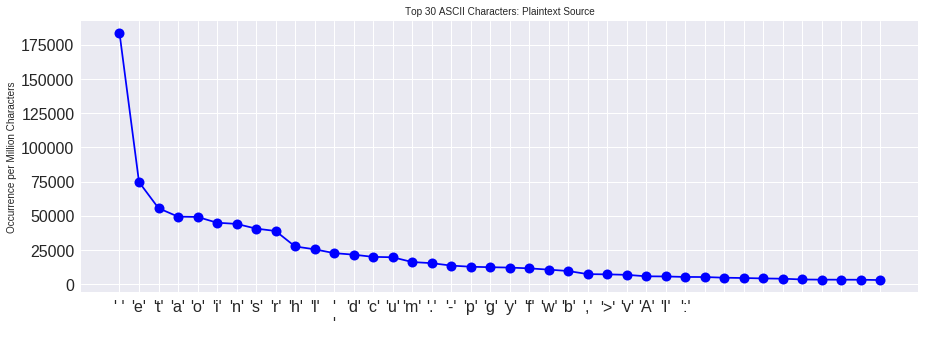

Of the 128 possible ASCII values, only 100 are used more than once per million


In [0]:
# create a bar chart to highlight the top 40 most common characters
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.arange(40),asciitop_df['char_per_million'].iloc[0:40],color='blue', marker='o', markersize=10)
ax.set_xticklabels(["'"+chr(asciinum)+"'" for asciinum in asciitop_df.index[0:30]])
ax.set_xticks(np.arange(40))
ax.tick_params(axis='both',labelsize=16)
plt.ylabel('Occurrence per Million Characters',fontsize=10)
plt.title('Top 30 ASCII Characters: Plaintext Source',fontsize=10)
plt.show()
print("Of the 128 possible ASCII values, only "+ str(sum(cpm_plaintext>1)) +" are used more than once per million")

In [0]:
# the 5000 most common traditional words
token_pattern = r"[a-zA-Z0-9!@#$&()<>'=\-]+"
totalchars = sum([len(cipherstring) for cipherstring in twenty_databunch.data])
vectorizer = CountVectorizer(analyzer='word', max_features=5000)
source_words = vectorizer.fit_transform(twenty_databunch.data)
worddictionary2 = vectorizer.vocabulary_

# the 5000 most common words, including one-letter words and symbols
totalchars = sum([len(cipherstring) for cipherstring in twenty_databunch.data])
vectorizer = CountVectorizer(analyzer='word', max_features=5000, token_pattern=token_pattern)
source_words = vectorizer.fit_transform(twenty_databunch.data)
worddictionary = vectorizer.vocabulary_
# the word-per-million score from plaintext English that we try to match in deciphering
wpm_plaintext = word_per_million(twenty_databunch.data,worddictionary)

# the 1000 most common English ngrams
n_ngram = 3
totalchars = sum([len(cipherstring) for cipherstring in twenty_databunch.data])
vectorizer = CountVectorizer(analyzer='char', 
                             max_features=1000,
                             lowercase = False,
                             ngram_range = (n_ngram,n_ngram) )
source_words = vectorizer.fit_transform(twenty_databunch.data)
ngramdictionary = vectorizer.vocabulary_
# the word-per-million score from plaintext English that we try to match in deciphering
npm_plaintext = ngram_per_million(twenty_databunch.data,ngramdictionary)

In [0]:
# this dictionary dataframe will show the common words
worddict_df = pd.DataFrame.from_dict(worddictionary, orient='index')
worddict_df.reset_index(inplace=True)
worddict_df.rename(index=str, columns={"index": "word", 0: "dict_index"},inplace=True)
worddict_df.set_index('dict_index',inplace=True)
worddict_df.sort_index(inplace=True)
worddict_df['words_per_million'] = wpm_plaintext
worddict_df.sort_values('words_per_million',ascending=False,inplace=True)
print("Top 10 Most Common Words/Symbols")
print(worddict_df.head(10))

Top 10 Most Common Words/Symbols
            word  words_per_million
dict_index                         
4468         the        6449.082807
4540          to        3245.825370
3222          of        3076.153569
500            a        2758.216647
649          and        2535.750792
2422          in        2091.473553
2529          is        1890.714344
2363           i        1832.275471
411            >        1736.858944
4465        that        1679.101812


<h1> 3. Mapping Cipher 1</h1>

Let's get started on cracking the cipher for `difficulty=1`.

<h2>Observed character frequencies</h2>


We can use the observed frequency of characters to identify them. In a transposition ciphertext, the characters show the same frequency of occurrence as normal English text. In contrast, a substitution cipher will produce ciphertext where each character has a different frequency than it would in English. But importantly, the probability distribution should look about the same--just with different characters.

If the shape of the probability distribution changes, the cipher is more complicated. This could likely fall in the category of a "polyalphabetic substitution cipher", where the substitutions mapping changes from one letter to the next. 

So let's look at the distribution of observed characters per million.

In [0]:
# we combine test and training data for greatest precision
cpm_train = char_per_million(train_df[train_df['difficulty']==1]['ciphertext'])
cpm_test =  char_per_million(test_df[test_df['difficulty']==1]['ciphertext'])
cpm_cipher = 0.67*cpm_test + 0.33*cpm_train

c1asciitop = np.argsort(-1*cpm_cipher)
c1asciitop_df = pd.DataFrame({'char':[chr(asciinum) for asciinum in c1asciitop],
                            'char_per_million':cpm_cipher[c1asciitop]},index=c1asciitop)

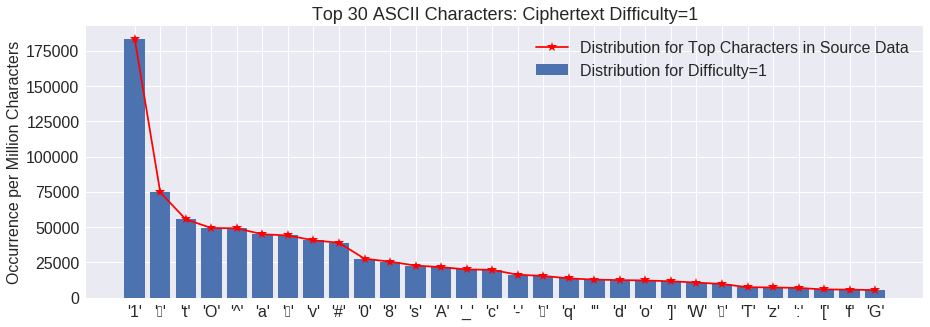

Of the 128 possible ASCII values, only 101 are used more than once per million


In [0]:
# create a bar chart to highlight the top 40 most common characters
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(30),
       asciitop_df['char_per_million'].iloc[0:30],
       tick_label = ["'"+chr(asciinum)+"'" for asciinum in c1asciitop_df.index[0:30]] )
ax.plot(np.arange(30),asciitop_df['char_per_million'].iloc[0:30],color='red', marker='*', markersize=10)
ax.tick_params(axis='both',labelsize=16)
plt.ylabel('Occurrence per Million Characters',fontsize=16)
plt.title('Top 30 ASCII Characters: Ciphertext Difficulty=1',fontsize=18)
plt.legend(['Distribution for Top Characters in Source Data','Distribution for Difficulty=1'],fontsize=16)
plt.show()
print("Of the 128 possible ASCII values, only "+ str(sum(cpm_cipher>1)) +" are used more than once per million")

This is what we expect to see from a substitution cipher. Note the red line showing the shape of the distribution for the top characters in the source data: different letters but almost exactly the same distribution!
 
Let's start deciphering by trying out a mapping between the characters of the plaintext and the ciphertext with the most similar frequency of occurrence. To do this, we will create an `asciimap` dataframe that connects each ciphertext characer in the index to a plaintext character in the `decipher` column. Then, if we just line up the frequency of letters ocurring in the plaintext English with the ciphertext, we can generate a first guess on a potential substitution mapping. Let's see how legible this is for the sample training data at `iloc[0]`:

In [0]:
asciimap = pd.DataFrame(asciitop, index=c1asciitop,columns=['decipher'])

In [0]:
textstring = train_df[train_df['difficulty']==1]['ciphertext'].iloc[0]
print('SAMPLE DECIPHER ATTEMPT:')
print(decipher_subst(textstring,asciimap))

SAMPLE DECIPHER ATTEMPT:
u )_ida 0haplynsIyM writes:
 A 
 A 1 family member of mine is suffering from a se>ere depression brought on
 A by menopause as well as a mental breaI down.  'he is being treated with
 A 9alydol with some success but the treatments being pro>ided through her
 A psychiatrist are not satisfactory.  'om


Not bad! At this point, the text is already legible enough to understand. We could finish deciphering manually by making a few corrections to the asciimap (i.e. we could turn the  >'s sideways to makes v's!). 

... but manual deciphering is no fun!  And automating and optimizing may create tools that we will need for deciphering the later ciphers.

<h1> Finding actual plaintext in the source and fine-tuning</h1>
The current `asciimap` substitution deciphering--while not perfect--is close enough to easily find the plaintext source and perfect the final substitutions in the cipher. Note that it takes about 25 seconds for `fuzzy wuzy` to find a match on a typical CPU.

In [0]:
%%time
# Go through the plain text from the category and find the matching entry
textstring = decipher_subst(train_df[train_df['difficulty']==1]['ciphertext'].iloc[0],asciimap)
textcategory = train_df[train_df['difficulty']==1]['target'].iloc[0]
sourcematch = process.extractOne(textstring, sourcetext_dict, scorer = fuzz.ratio)

CPU times: user 20.9 s, sys: 0 ns, total: 20.9 s
Wall time: 20.9 s


In [0]:
print('Found a match in source data with "fuzz.ratio" score of ' + str(fuzz.ratio(textstring,sourcematch[0])))
print('Source data found in category = ' + category_names[chunk_df['target'].iloc[sourcematch[2]]])
print('Matching text below:')
print('----------------')
print(sourcematch[0])
print(' ')

Found a match in source data with "fuzz.ratio" score of 94
Source data found in category = sci.med
Matching text below:
----------------
u (Lida Chaplynsky) writes:
 > 
 > A family member of mine is suffering from a severe depression brought on
 > by menopause as well as a mental break down.  She is being treated with
 > Halydol with some success but the treatments being provided through her
 > psychiatrist are not satisfactory.  Som
 


 While this level of accuracy is probably fine for identifying most of the `difficulty=1` ciphers, we may want to perfect the decryption. Getting the first cipher completely correct could help with the others.
 
 To fine-tune the mapping, let's take the identified matches and figure out which characters are not mapped correctly. We need a fairly large subset to find the rare characters, like "K", but going through so many example ciphers to find the rare characters eats significant time! For this step, it is helpful to use parallel processing (done here via `dask`).

In [0]:
# subsample of ciphertext
subset_size = 300
tune_df = train_df[np.logical_and(train_df['difficulty']==1,
                                    np.array([len(train_df['ciphertext'].iloc[idx]) for idx in range(len(train_df))])>250)]
tuneindices = tune_df.index[:subset_size]
        
# function to match to source data for same category and length between 280 and 1200 characters
def finetunematch(idx):
    textstring = decipher_subst(tune_df['ciphertext'].loc[idx],asciimap)
    selectindices = np.logical_and(chunk_df['target']==tune_df['target'].loc[idx],chunk_df['length']>250)
    sourcematch = process.extractOne(textstring, 
                                     list(compress(chunks_plaintext, selectindices)), 
                                     scorer = fuzz.ratio)
    return sourcematch[0], textstring, sourcematch[1]

# parallel evaluation using Dask (big benefits for more CPUs)
par_compute = [delayed(finetunematch)(idx) for idx in tuneindices]
output_arrays = compute(*par_compute, scheduler='processes')

[########################################] | 100% Completed |  9min 42.0s
[########################################] | 100% Completed |  9min 42.0s


To help ensure the matches are high quality, let's only use matches where the text similarity, as measured by the `fuzz.ratio`, is higher than 80.

In [0]:
# select those with relatively high fuzzy.ratio scores
minfuzzyscore = 80
sourcematch_array = [arrays[0] for arrays in output_arrays]
decipher_array = [arrays[1] for arrays in output_arrays]
fuzzyscores_array = np.array([arrays[2] for arrays in output_arrays])
sourcematch_array = list(compress(sourcematch_array, (fuzzyscores_array>=minfuzzyscore) ))
decipher_array = list(compress(decipher_array, (fuzzyscores_array>=minfuzzyscore) ))
cipher_array =  tune_df[:subset_size]['ciphertext']
cipher_array = list(compress(cipher_array, (fuzzyscores_array>=minfuzzyscore) ))

In [0]:
print('In subsample, ' + str(np.sum(fuzzyscores_array>=minfuzzyscore)) + ' of the ' + str(subset_size) + ' have fuzzy.ratios > ' 
       + str(minfuzzyscore) + ' and will be used for fine-tuning')
print(' ')
print('Before fine-tuning the sub-sample:')
gof = goodness_of_fit(cipher_array,asciimap=asciimap)
print('Average fuzzy.ratio = ' + str(np.mean(fuzzyscores_array[fuzzyscores_array>=minfuzzyscore])))

In subsample, 270 of the 300 have fuzzy.ratios > 80 and will be used for fine-tuning
 
Before fine-tuning the sub-sample:
   Goodness-of-Fit vs Source Text   
Number of Recognized Words = 7889
Word-per-Million Similarity = 0.5606182583046375
Ngram-per-Million Similarity = 0.7036158859935282
Average fuzzy.ratio = 91.24814814814815


Using those matches, some of the most common character replacements needed to match the proposed decipher with the source text (using Levenshtein distance edits) are:

In [0]:
# initialize asciiswitchmat, a 128x128 matrix with rows numbers corresponding to ascii characters
# that should be replaced by the ascii character of the column number
asciiswitchmat = np.zeros([128,128],dtype=int)
asciicount = np.zeros((128,), dtype=int)

for i, textstring in enumerate(decipher_array):
    asciiswitchmat += leven_replace_matrix(textstring,sourcematch_array[i])
    asciicount += np.histogram(string2ascii(textstring),np.arange(129))[0]

deciphererror_dict = {'ascii_replacement': [np.argmax(asciiswitchmat[i,...]) for i in range(128)],
                      'char_decipher': [chr(i) for i in range(128)],
                      'char_replacement': [chr(np.argmax(asciiswitchmat[i,...])) for i in range(128)],
                      'numError': np.sum(asciiswitchmat,axis=1),
                      'numReplace': [asciiswitchmat[i,np.argmax(asciiswitchmat[i,...])] for i in range(128)],
                      'totalObs': asciicount}

deciphererror_df = pd.DataFrame.from_dict(deciphererror_dict)
deciphererror_df['pctError'] = deciphererror_df['numError'] / deciphererror_df['totalObs']
deciphererror_df['pctBestReplace'] = deciphererror_df['numReplace'] / deciphererror_df['numError']  
deciphererror_df.sort_values(by=['pctError'],ascending=False,inplace=True)
deciphererror_df.head(10)

,ascii_replacement,char_decipher,char_replacement,numError,numReplace,totalObs,pctError,pctBestReplace
113,92,q,\,1,1,1,1.000000,1.0
40,61,(,=,177,177,189,0.936508,1.0
93,37,],%,3,3,4,0.750000,1.0
71,106,G,j,81,81,111,0.729730,1.0
90,93,Z,],10,10,14,0.714286,1.0
96,90,`,Z,8,8,12,0.666667,1.0
88,82,X,R,90,90,140,0.642857,1.0
63,122,?,z,77,77,120,0.641667,1.0
106,47,j,/,20,20,32,0.625000,1.0
41,40,),(,120,120,192,0.625000,1.0


In [0]:
# correct the identified errors in character substitution
errorprone = np.logical_and(deciphererror_df['totalObs']>=1,
                            np.logical_and(deciphererror_df['pctError']>=0.01*(100-minfuzzyscore),
                                           deciphererror_df['pctBestReplace']>=0.5)),
decipherchars = deciphererror_df.index[errorprone]
improvementchars = deciphererror_df['ascii_replacement'].loc[errorprone].values
tmpasciimap = asciimap.copy()
for i,decipherchar in enumerate(decipherchars):
    asciimap['decipher'].loc[tmpasciimap['decipher'].values==decipherchar] = improvementchars[i]

Now we should have a fairly accurate solution. Let's check goodness-of-fit statistics as well as our decryption of the sample cipher at `iloc[0]`

In [0]:
print('After fine-tuning the sub-sample:')
gof = goodness_of_fit(cipher_array,asciimap=asciimap)

After fine-tuning the sub-sample:
   Goodness-of-Fit vs Source Text   
Number of Recognized Words = 10348
Word-per-Million Similarity = 0.8087210067125508
Ngram-per-Million Similarity = 0.7888522723335183


In [0]:
textstring = train_df[train_df['difficulty']==1]['ciphertext'].iloc[0]
print('FINAL DECIPHER:')
print(decipher_subst(textstring,asciimap))

FINAL DECIPHER:
u (Lida Chaplynsky) writes:
 > 
 > A family member of mine is suffering from a severe depression brought on
 > by menopause as well as a mental break down.  She is being treated with
 > Halydol with some success but the treatments being provided through her
 > psychiatrist are not satisfactory.  Som


This looks great and exactly matches the source. Let's now decipher all the test data.

In [0]:
%%time
test_df['plaintext'] = ['']*len(test_df)
# fill in plaintext for test data
c1indices = test_df[test_df['difficulty']==1].index
test_df.loc[c1indices,'plaintext'] = [decipher_subst(test_df['ciphertext'].loc[idx],asciimap) for idx in c1indices]

In [0]:
test_df.head()

,Id,difficulty,ciphertext,length
0,ID_65f17e60f,1,a1t01OAAata^O81 /e1'O_f1q1at;v1'#ttos1QQv8...,300
1,ID_ba83b2917,2,^V*$z8d*e4z88SF38e*8|8SFO8Hh}m}[8^7$8A84ej{...,300
2,ID_ff4e56b9c,3,$*c8?l{{?$8Giw{8{7$8Z9J8Edj?O$*8_n}{87U$8{7...,300
3,ID_81b64cbc5,2,"nL6! 8lL6M84VkVoh$887h}8h}88 ,8z888888888...",300
4,ID_851f738e5,2,}8z8}{Vv$H8h86*4$hVWz8z8\%p8\Sp8lf9V*{7v[8\...,300


In [0]:
train_df.head()

,Id,difficulty,ciphertext,target
0,ID_88b9bbd73,4,"ob|I K?zzhX*L{83B3Z,FuL*Pusm$83L\t@r$$*38,8s...",10
1,ID_f489bd59f,1,c1|FaAO120O'8ovfoy1W#atvGs1[1s1[1/1]O-a8o1-...,13
2,ID_f90fee9c7,2,1*e4N8$f$0ccOuihkHek$k*V*hoeV$Hj8VhH8...,19
3,ID_8303ced65,1,O8v^10O#to1'#^'^tv1^]s111t01Otaq>-ata_1...,17
4,ID_72abc2cb7,2,eV}H}khfe4b8'S.Vc}{A .#VikV.fV?{$f7$Hjb8...,0


In [0]:
train_df1=train_df[train_df['difficulty']==1]

In [0]:
def decipher_subst1(textstring):
    inarray = string2ascii(textstring)
    outarray = np.zeros(len(inarray),dtype=np.int8)
    for asciival in asciimap.index:
        outarray[inarray==asciival] = asciimap['decipher'].loc[asciival]
    return ascii2string(outarray)


In [0]:
train_df1['deciphrer_text']=train_df1['ciphertext'].apply(decipher_subst1)

In [0]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

In [0]:
def removestop(text):
  words=text.split()
  no_stop=[sno.stem(word) for word in words if word not in stop and len(word)>2]
  final_text = " ".join(no_stop)
  return final_text

def cleanpunc(sentence):
  cleaned = re.sub(r'[?|!|\'|"|{}#*<>+~@$%&:\x02\x08\x1b;-_]',r'',sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/-]',r' ',cleaned)
  x = re.sub(r"([0-9])", r"", cleaned)
  return x

In [0]:
train_df1['Cleaned_text']=train_df1['deciphrer_text'].map(cleanpunc).map(removestop)
chunk_df['Cleaned_text']=chunk_df['plaintext'].map(cleanpunc).map(removestop)


In [0]:
X_train=chunk_df['Cleaned_text'].values
X_test=train_df1['Cleaned_text'].values
y_train=chunk_df['target']
y_test=train_df1['target']

In [0]:
test_df1=test_df[test_df['difficulty']==1]
test_df1['deciphrer_text']=test_df1['ciphertext'].apply(decipher_subst1)
test_df1['Cleaned_text']=test_df1['deciphrer_text'].map(cleanpunc).map(removestop)

In [0]:
Kaggle_test1=test_df1['Cleaned_text'].values

<h2>Using SGDClassifier</h2>

In [0]:
clf0 = Pipeline([
    ('vectorizer', sktext.CountVectorizer(lowercase=True, ngram_range = (1,2))),
    ('tfidf', sktext.TfidfTransformer()),
    ('clf0', SGDClassifier(loss='log',alpha=0.0001,penalty='l2'))
])

clf0.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [0]:
predictions0=clf0.predict(X_test)
print(classification_report(y_test,predictions0 ))

              precision    recall  f1-score   support

           0       0.80      0.40      0.54       420
           1       0.81      0.59      0.68       465
           2       0.17      0.83      0.28       360
           3       0.68      0.36      0.47       346
           4       0.97      0.19      0.31       320
           5       0.61      0.53      0.57       466
           6       0.91      0.24      0.38       361
           7       0.86      0.45      0.59       331
           8       0.92      0.42      0.58       380
           9       0.94      0.52      0.67       486
          10       0.78      0.75      0.76       540
          11       0.71      0.70      0.70       563
          12       0.94      0.27      0.42       344
          13       0.87      0.69      0.77       482
          14       0.83      0.70      0.76       576
          15       0.57      0.86      0.69       765
          16       0.75      0.59      0.66       471
          17       0.45    

<h2>Using KNN</h2>

In [0]:
clf = Pipeline([
    ('vectorizer', sktext.CountVectorizer(lowercase=True, ngram_range = (1,2))),
    ('tfidf', sktext.TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors = 1))
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...ki',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'))])

In [0]:
predictions=clf.predict(X_test)

In [0]:
print(classification_report(y_test,predictions ))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       420
           1       1.00      0.99      0.99       465
           2       0.99      0.99      0.99       360
           3       0.99      0.97      0.98       346
           4       1.00      0.99      0.99       320
           5       0.99      0.77      0.87       466
           6       1.00      0.96      0.98       361
           7       1.00      0.99      0.99       331
           8       0.99      0.97      0.98       380
           9       1.00      0.98      0.99       486
          10       0.69      1.00      0.82       540
          11       0.99      0.97      0.98       563
          12       0.99      0.99      0.99       344
          13       1.00      0.98      0.99       482
          14       1.00      0.99      0.99       576
          15       1.00      0.99      1.00       765
          16       1.00      0.92      0.95       471
          17       1.00    

Confusion_Matrix for Difficulty == 1


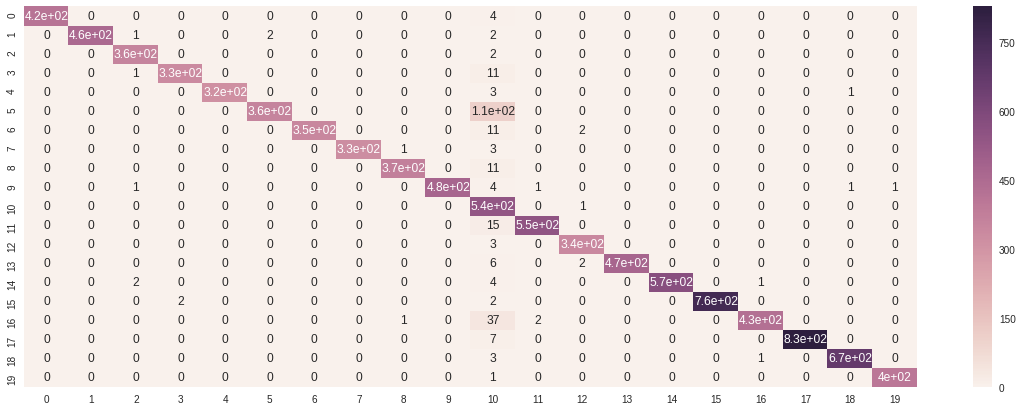

In [0]:
plt.figure(figsize=(20,7))
sns.heatmap(metrics.confusion_matrix(y_test,predictions),annot=True)
print("Confusion_Matrix for Difficulty == 1")
print("="*80)

In [0]:
test_df1['Predicted']=clf.predict(Kaggle_test1)

<h2>4. Mapping Difficulty 2</h2>
We can follow the exact same proces in examining cipher #2. First let's look at the distribution of ascii characters.

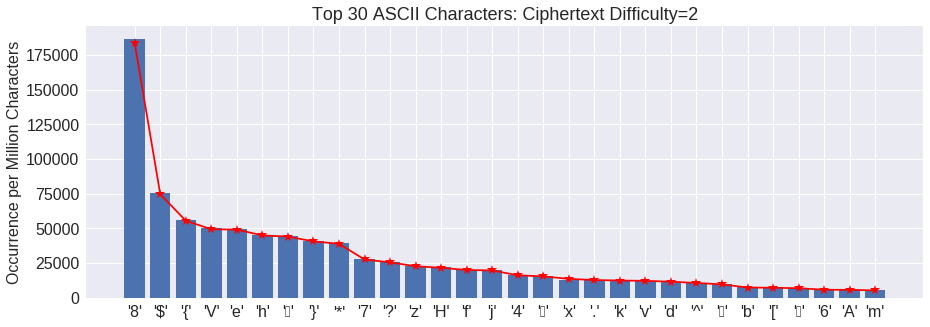

Of the 128 possible ASCII values, only 99 are used more than once per million
CPU times: user 23.3 s, sys: 193 ms, total: 23.5 s
Wall time: 23.2 s


In [0]:
%%time
cpm_plaintext = char_per_million(chunks_plaintext)
asciitop = np.argsort(-1*cpm_plaintext)
asciitop_df = pd.DataFrame({'char':[chr(asciinum) for asciinum in asciitop],'char_per_million':cpm_plaintext[asciitop]},index=asciitop)

# we combine test and training data for greatest precision
cpm_train = char_per_million(train_df[train_df['difficulty']==2]['ciphertext'])
cpm_test =  char_per_million(test_df[test_df['difficulty']==2]['ciphertext'])
cpm_cipher = 0.67*cpm_test + 0.33*cpm_train

c2asciitop = np.argsort(-1*cpm_cipher)
c2asciitop_df = pd.DataFrame({'char':[chr(asciinum) for asciinum in c1asciitop],
                            'char_per_million':cpm_cipher[c2asciitop]},index=c2asciitop)

# create a bar chart to highlight the top 40 most common characters
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(30),
       c2asciitop_df['char_per_million'].iloc[0:30],
       tick_label = ["'"+chr(asciinum)+"'" for asciinum in c2asciitop_df.index[0:30]] )
ax.plot(np.arange(30),asciitop_df['char_per_million'].iloc[0:30],color='red', marker='*', markersize=10)
ax.tick_params(axis='both',labelsize=16)
plt.ylabel('Occurrence per Million Characters',fontsize=16)
plt.title('Top 30 ASCII Characters: Ciphertext Difficulty=2',fontsize=18)
plt.show()
print("Of the 128 possible ASCII values, only "+ str(sum(cpm_cipher>1)) +" are used more than once per million")

Looks like another substititution cipher. And even though this Kaggle competition creates the ciphertext by encoding with cipher #1 and then with cipher #2 to create the difficulty=2 ciphers, we can simply solve for the composition mapping between the plaintext in the source and the ciphertext.

In [0]:
%%time
asciimap2 = pd.DataFrame(asciitop, index=c2asciitop,columns=['decipher'])
# Go through the plain text from the category and find the matching entry
textstring = decipher_subst(train_df[train_df['difficulty']==2]['ciphertext'].iloc[0],asciimap2)
textcategory = train_df[train_df['difficulty']==2]['target'].iloc[0]
sourcematch = process.extractOne(textstring, sourcetext_dict, scorer = fuzz.ratio)

print('Found a match in source data with "fuzz.ratio" score of ' + str(fuzz.ratio(textstring,sourcematch[0])))
print('Source data found in category = ' + category_names[chunk_df['target'].iloc[sourcematch[2]]])
print('Original deciphering using character frequency:')
print('----------------')
print(textstring)
print(' ')
print('Matching text below:')
print('----------------')
print(sourcematch[0])
print(' ')

Found a match in source data with "fuzz.ratio" score of 85
Source data found in category = talk.religion.misc
Original deciphering using character frequency:
----------------
From' ece5MM2/_bigdog.engr.ari7ona.edu *Oavid Anderson(
 SubUect' Pe' Christian 3wned 3rgani7ation list
 3rgani7ation' 8niversity of Ari7ona
 @ines' 1"
 
 In article <ja$_byu.edu, $stephan_sasb.byu.edu *Stephan Fassmann( writes'
 ,In article <1""NApr1N.M29426.229N2_mnemosyne.cs.du.edu, :cochran_nyW.
 
Matching text below:
----------------
From: ece_0028@bigdog.engr.arizona.edu (David Anderson)
 Subject: Re: Christian Owned Organization list
 Organization: University of Arizona
 Lines: 19
 
 In article <?a$@byu.edu> $stephan@sasb.byu.edu (Stephan Fassmann) writes:
 >In article <1993Apr13.025426.22532@mnemosyne.cs.du.edu> kcochran@nyx.
 
CPU times: user 20.9 s, sys: 11.8 ms, total: 20.9 s
Wall time: 20.9 s


Again, just using the character frequency is not a bad place to start. We can then fine-tune by matching to the source text.

In [0]:
# subsample of ciphertext
subset_size = 300
tune_df = train_df[np.logical_and(train_df['difficulty']==2,
                                    np.array([len(train_df['ciphertext'].iloc[idx]) for idx in range(len(train_df))])>250)]
tuneindices = tune_df.index[:subset_size]
        
# function to match to source data for same category and length greater than 250 characters
def finetunematch2(idx):
    textstring = decipher_subst(tune_df['ciphertext'].loc[idx],asciimap2)
    selectindices = np.logical_and(chunk_df['target']==tune_df['target'].loc[idx],chunk_df['length']==len(textstring))
    sourcematch = process.extractOne(textstring, 
                                     list(compress(chunks_plaintext, selectindices)), 
                                     scorer = fuzz.ratio)
    return sourcematch[0], textstring, sourcematch[1]

# parallel evaluation using Dask (big benefits for more CPUs)
par_compute = [delayed(finetunematch2)(idx) for idx in tuneindices]
output_arrays = compute(*par_compute, scheduler='processes')

[########################################] | 100% Completed | 12min 54.0s
[########################################] | 100% Completed | 12min 54.0s
[########################################] | 100% Completed | 12min 54.1s


In [0]:
# select those with relatively high fuzzy.ratio scores
minfuzzyscore = 80
sourcematch_array = [arrays[0] for arrays in output_arrays]
decipher_array = [arrays[1] for arrays in output_arrays]
fuzzyscores_array = np.array([arrays[2] for arrays in output_arrays])
sourcematch_array = list(compress(sourcematch_array, (fuzzyscores_array>=minfuzzyscore) ))
decipher_array = list(compress(decipher_array, (fuzzyscores_array>=minfuzzyscore) ))
cipher_array =  tune_df[:subset_size]['ciphertext']
cipher_array = list(compress(cipher_array, (fuzzyscores_array>=minfuzzyscore) ))
print('In subsample, ' + str(np.sum(fuzzyscores_array>=minfuzzyscore)) + ' of the ' + str(subset_size) + ' have fuzzy.ratios > ' 
       + str(minfuzzyscore) + ' and will be used for fine-tuning')
print(' ')
print('Before fine-tuning the sub-sample:')
gof = goodness_of_fit(cipher_array,asciimap=asciimap2)
print('Average fuzzy.ratio = ' + str(np.mean(fuzzyscores_array[fuzzyscores_array>=minfuzzyscore])))

In subsample, 289 of the 300 have fuzzy.ratios > 80 and will be used for fine-tuning
 
Before fine-tuning the sub-sample:
   Goodness-of-Fit vs Source Text   
Number of Recognized Words = 9033
Word-per-Million Similarity = 0.7120444590237837
Ngram-per-Million Similarity = 0.7012825554233288
Average fuzzy.ratio = 94.5432525951557


In [0]:
# initialize asciiswitchmat, a 128x128 matrix with rows numbers corresponding to ascii characters
# that should be replaced by the ascii character of the column number
asciiswitchmat = np.zeros([128,128],dtype=int)
asciicount = np.zeros((128,), dtype=int)

for i, textstring in enumerate(decipher_array):
    asciiswitchmat += leven_replace_matrix(textstring,sourcematch_array[i])
    asciicount += np.histogram(string2ascii(textstring),np.arange(129))[0]

deciphererror_dict2 = {'ascii_replacement': [np.argmax(asciiswitchmat[i,...]) for i in range(128)],
                      'char_decipher': [chr(i) for i in range(128)],
                      'char_replacement': [chr(np.argmax(asciiswitchmat[i,...])) for i in range(128)],
                      'numError': np.sum(asciiswitchmat,axis=1),
                      'numReplace': [asciiswitchmat[i,np.argmax(asciiswitchmat[i,...])] for i in range(128)],
                      'totalObs': asciicount}

deciphererror_df2 = pd.DataFrame.from_dict(deciphererror_dict2)
deciphererror_df2['pctError'] = deciphererror_df2['numError'] / deciphererror_df2['totalObs']
deciphererror_df2['pctBestReplace'] = deciphererror_df2['numReplace'] / deciphererror_df2['numError']  
deciphererror_df2.sort_values(by=['numError'],ascending=False,inplace=True)
deciphererror_df2.head()

,ascii_replacement,char_decipher,char_replacement,numError,numReplace,totalObs,pctError,pctBestReplace
32,32,,,699,696,15920,0.043907,0.995708
39,58,',:,287,287,452,0.634956,1.000000
101,101,e,e,278,278,6944,0.040035,1.000000
62,44,>,",",267,267,617,0.432739,1.000000
58,107,:,k,230,230,461,0.498915,1.000000


In [0]:
# correct the identified errors in character substitution
errorprone = np.logical_and(deciphererror_df2['totalObs']>=1,
                            np.logical_and(deciphererror_df2['pctError']>=0.1,
                                           deciphererror_df2['pctBestReplace']>=0.5)),
decipherchars = deciphererror_df2.index[errorprone]
improvementchars = deciphererror_df2['ascii_replacement'].loc[errorprone].values
tmpasciimap = asciimap2.copy()
for i,decipherchar in enumerate(decipherchars):
    asciimap2['decipher'].loc[tmpasciimap['decipher'].values==decipherchar] = improvementchars[i]

In [0]:
print('After fine-tuning the sub-sample:')
gof = goodness_of_fit(cipher_array,asciimap=asciimap2)

After fine-tuning the sub-sample:
   Goodness-of-Fit vs Source Text   
Number of Recognized Words = 10926
Word-per-Million Similarity = 0.8480858888243816
Ngram-per-Million Similarity = 0.755025097205732


In [0]:
textstring = train_df[train_df['difficulty']==2]['ciphertext'].iloc[0]
print('FINAL DECIPHER:')
print(decipher_subst(textstring,asciimap2))

FINAL DECIPHER:
From: ece_0028@bigdog.engr.arizona.edu (David Anderson)
 Subject: Re: Christian Owned Organization list
 Organization: University of Arizona
 Lines: 19
 
 In article <?a$@byu.edu> $stephan@sasb.byu.edu (Stephan Fassmann) writes:
 >In article <1993Apr13.025426.22532@mnemosyne.cs.du.edu> kcochran@nyx.


For our submission, let's only decipher difficulty-2, but let's also use this to make an attempt at difficulty=3 in case this allows our fuzzy matching to recognize some of them as well. 

In [0]:
def decipher_subst2(textstring):
    inarray = string2ascii(textstring)
    outarray = np.zeros(len(inarray),dtype=np.int8)
    for asciival in asciimap2.index:
        outarray[inarray==asciival] = asciimap2['decipher'].loc[asciival]
    return ascii2string(outarray)


In [0]:
train_df2=train_df[train_df['difficulty']==2]

In [0]:
train_df2['deciphrer_text']=train_df2['ciphertext'].apply(decipher_subst2)

In [0]:

train_df2['Cleaned_text']=train_df2['deciphrer_text'].map(cleanpunc).map(removestop)


In [0]:
train_df2.head()

,Id,difficulty,ciphertext,target,length,deciphrer_text,Cleaned_text
2,ID_f90fee9c7,2,1*e4N8$f$0ccOuihkHek$k*V*hoeV$Hj8VhH8...,19,300,From: ece_0028@bigdog.engr.arizona.edu (David ...,rom ecebigdog engr arizona edu avid nderson ub...
4,ID_72abc2cb7,2,eV}H}khfe4b8'S.Vc}{A .#VikV.fV?{$f7$Hjb8...,0,300,o.asd.sgi.com> <1pa0stINNpqa@gap.caltech.edu> ...,asd sgi com pastpqagap caltech edu panfbjfido ...
7,ID_74ae76ad1,2,{V?mhk[8ed8z8fej*}$[8Vej{8}f7ee?x{ex^e*m8VH...,18,300,"talking, of \n course, about school-to-work an...",talk cours school work also job econom recover...
9,ID_8dd34799b,2,}8}Vd$*8^h{78V84e*$z8b?h$*V?87VHkj8?V^8{7V...,16,300,s safer with a more\n >liberal handgun law tha...,safer liber handgun law without choic leas oth...
11,ID_f8ca8a89c,2,$V{8{e8{7$8H$dhh{he8ed8V{7$h}4[8^7hf78h}8B...,0,235,"evant to the definition of atheism, which is '...",evant definit atheism lack belief god rank wye...


In [0]:
X_test2=train_df2['Cleaned_text'].values
y_test2= train_df2['target']


In [0]:
Predictions=clf.predict(X_test2)

In [0]:
print(classification_report(y_test2,Predictions ))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       455
           1       1.00      0.97      0.98       528
           2       0.99      0.55      0.71       652
           3       0.99      0.98      0.99       391
           4       1.00      0.97      0.98       315
           5       0.99      0.99      0.99       550
           6       0.99      0.97      0.98       310
           7       1.00      0.99      0.99       405
           8       1.00      0.99      0.99       387
           9       0.99      0.98      0.98       301
          10       0.59      1.00      0.74       580
          11       1.00      1.00      1.00       651
          12       1.00      0.98      0.99       396
          13       1.00      0.99      0.99       500
          14       1.00      0.99      1.00       566
          15       1.00      0.99      0.99       692
          16       0.99      0.98      0.99       536
          17       1.00    

Confusion_Matrix for Difficulty == 2


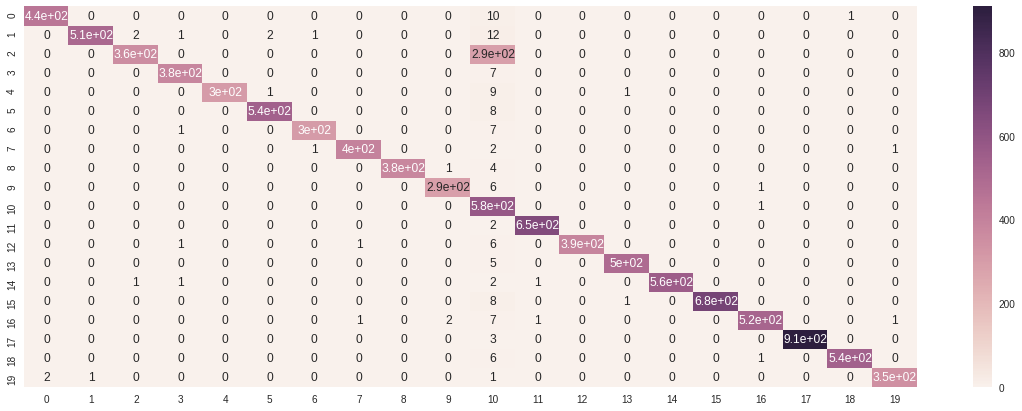

In [0]:
plt.figure(figsize=(20,7))
sns.heatmap(metrics.confusion_matrix(y_test2,Predictions),annot=True)
print("Confusion_Matrix for Difficulty == 2")
print("="*120)

In [0]:
test_df2=test_df[test_df['difficulty']==2]

In [0]:
test_df2['deciphrer_text']=test_df2['ciphertext'].apply(decipher_subst2)
test_df2['Cleaned_text']=test_df2['deciphrer_text'].map(cleanpunc).map(removestop)
test_df2.head()

,Id,difficulty,ciphertext,length,deciphrer_text,Cleaned_text
1,ID_ba83b2917,2,^V*$z8d*e4z88SF38e*8|8SFO8Hh}m}[8^7$8A84ej{...,300,"ware\n from\n 5 1/4 or 3 1/2 disks, when I mou...",ware disk mount second third fourth disk doesn...
3,ID_81b64cbc5,2,"nL6! 8lL6M84VkVoh$887h}8h}88 ,8z888888888...",300,HEAVY METAL magazine. This is NOT \n ...,magazin music mag realli neato mag iger oebius...
4,ID_851f738e5,2,}8z8}{Vv$H8h86*4$hVWz8z8\%p8\Sp8lf9V*{7v[8\...,300,s \n stayed in Armenia!\n \n [(*] [1] McCarthy...,stay rmenia carthi uslim inor opul ttoman nato...
8,ID_f9dc3c084,2,8.?$V}$8j}$8$}Vk*$2f$.{8${3ccc8j}$*}z888...,300,please use vesa.grn(except et4000 users).\n ...,pleas use vesa grn except user find vesa drive...
14,ID_400346f25,2,1*e4N84}.*Vkj$i}j.$*he*4f^}{|SS8lhm$8E.*Vk...,300,From: msprague@superior.mcwbst311b (Mike Sprag...,rom mspraguesuperior mcwbstb ike pragu ubject ...


In [0]:
kaggle_test2=test_df2['Cleaned_text'].values
Pred=clf.predict(kaggle_test2)
test_df2['Predicted']=Pred

<h1>5.Mapping level 3</h1>

In [0]:
#aciimap2 ====> key
key = [['8', ' '],['$', 'e'],['{', 't'],['V', 'a'],['e', 'o'],['h', 'i'],['\x10', 'n'],['}', 's'],['*', 'r'],['7', 'h'],['?', 'l'],['z', '\n'],['H', 'd'],['f', 'c'],['j', 'u'],['4', 'm'],['\x1a', '.'],['x', '-'],['.', 'p'],['k', 'g'],['v', 'y'],['d', 'f'],['^', 'w'],['\x18', 'b'],['b', '>'],['[', ','],['\x03', 'v'],['6', 'A'],['A', 'I'],['m', 'k'],['B', "'"],['N', ':'],['E', 'S'],['S', '1'],['\x06', 'T'],['(', 'X'],['c', '0'],['l', 'M'],['9', 'C'],['%', '*'],['\x02', ')'],['\x08', '('],['O', '2'],['a', '='],['\x0c', 'N'],['&', 'R'],['@', 'P'],['|', '3'],['\x7f', 'D'],[',', 'O'],['i', '@'],['L', 'E'],['M', 'L'],['=', '"'],['C', '9'],['X', '\t'],['\x1b', '5'],['1', 'F'],['n', 'H'],['Q', 'B'],['3', '4'],['0', '_'],['2', 'x'],['s', 'W'],['<', '6'],[')', 'G'],['_', 'j'],['G', 'U'],['u', '8'],['\x19', '?'],['-', '?'],['o', 'z'],['F', '/'],[';', '|'],['\t', 'J'],['~', 'K'],['W', '!'],['!', 'V'],["'", '<'],[' ', 'Y'],['\n', '+'],['#', 'q'],['I', '$'],[':', '#'],[']', 'Q'],['/', '^'],['g', '#'],['\x1e', '%'],['p', ']'],['5', ']'],['\\', '['],['`', 'Z'],['t', '&'],['y', '&'],['R', 'Z'],['P', '}'],['r', '{'],['"', '\r'],['T', 'u'],['Z', '\x02']]
decrypt_map_2 = {i:j for i,j in key}

In [0]:
diff_3_data = train_df.query("difficulty == 3").copy()
diff_3_data["trans"] = diff_3_data["ciphertext"].apply(
    lambda x:''.join([decrypt_map_2.get(k,'?') for k in x])
)

##top starting letters 
diff_3_data.trans.str[:5].value_counts().head()

FrMmZ    1369
          153
o>@>g      79
EHbje      49
 the       40
Name: trans, dtype: int64

In [0]:
Counter([i[:5] for i in plaintext_data.data]).most_common(5)

[('From:', 18038),
 ('Subje', 506),
 ('Organ', 204),
 ('Distr', 27),
 ('Nntp-', 25)]

In [0]:
pd.options.display.max_columns = 300

pd.options.display.max_rows = 300

plain_1, cipher_1 = [
    '''From: trussell@cwis.unomaha.edu (Tim Russell)\nSubject: Re: Once tapped, your code is no good any more.\nOrganization: University of Nebraska at Omaha\nDistribution: na\nLines: 18\n\ngeoff@ficus.cs.ucla.edu (Geoffrey Kuenning) writes:\n\n>It always amazes me how quick people are to blame whatever\n>administr''',
    '''FrMmZ tr8ssellkWw#s.znWm}h\t.e2H (T#m R]ssell)\n L?bjeut/ Re? Onue tUppeE, @fzr &&?e zs n@ ugo} $n\n m?re.# OrzUnM>?tkWnd $nzversMt8 gf Nebr?s\n\x02 :t Om9h\x02g DMstr8b@tkWnd n\t# B#nesu 10k f 0eMizk?#g-s.\ns.Mkl\x02.eU] (GeoM?re\n K>ennznz) wrWtesZk & #2t }lw\t0s \x02m?8es me how q{8uo peMple \x02re t] bl\x02me wh$tever& #'''
    
]

plain_2, cipher_2 = [
    '''From: hollasch@kpc.com (Steve Hollasch)\nSubject: Re: Raytracing Colours?\nSummary: Illumination Equations\nOrganization: Kubota Pacific Computer, Inc.\nLines: 44\n\nasecchia@cs.uct.ac.za (Adrian Secchia) writes:\n| When an incident ray (I) strikes an object at point P ...  The reflected\n| ray (R) and the ''',
    '''FrMmZ h]ll\x02sWhi{p&.\n#m (Eteve {fll'sch)i ZHbje-t? ReZ RU\ntr$okn& C&l#?rs?f ?]mmarfI Sll>mzn\x02tW@n ?q@Ity&ns> Or{\x02n#8at]{nZ K>bMt\x02 PUu80k& C&mpMter, dnu.& 1inesa 44k f :sekuhW\x02yos.z&t.}i.y\x02 (AUrHan LeWuh\n9) wrMtes?f | chen ?n kn&>?ent r9\n (\x02) strHkes ?n {bjeut :t pMMnt P ...  The rezleute?& | rIu (R) '''
]

plain_3, cipher_3 = [
    '''From: snichols@adobe.com (Sherri Nichols)\nSubject: Re: Braves Pitching UpdateDIR\nOrganization: Adobe Systems Incorporated\nLines: 13\n\nIn article <1993Apr15.010745.1@acad.drake.edu> sbp002@acad.drake.edu writes:\n>or second starter.  It seems to me that when quality pitchers take the\n>mound, the other ''',
    '''FrMmZ snWuh{lsiIa&be.iMm ($herr# NHchkls)k $>bjektZ Re? ?r$ves P#tghyno $p2\x02teD\x02Rc Org?n8W:tz@n? AE{be ?=stems 2n\n#rpMr\x02teUc L]nesI !3{ # Sn UrtMWle <ZdB3AprL5.o\x02#?45.ZzaH$E.\x02r9?e.e1Hz sbp>i90\tk\x02U.:ra8e.e?H wr\ntes?f k@r seWfnL st?rter.  ?t seems t# me th9t when qH?lHty p]tWhers t\x02oe the# cm]Hn?, the'''
]

plain_4, cipher_4 = [
    '''From: art@cs.UAlberta.CA (Art Mulder)\nSubject: comp.windows.x: Getting more performance out of X.  FAQ\nSummary: This posting contains a list of suggestions about what you can do to get the best performance out of X on your workstation -- without buying more hardware.\nKeywords: FAQ speed X\nNntp-Posti''',
    '''FrMmZ UrtkWs./AlbertI.CA (Art \nfl?er)# $@bjeMt: H{mp.wMn\x02Mws.xZ GettWnz m{re per0urm?n\ne #?t @0 X.  FAQc S{mm$r\n/ Thzs p@stWnz WfntIyns } lust Mi s@?gest]{ns \x02b??t wh\x02t #@? oIn a& t# {et the best perifrm'nce k?t @y X Mn \n]Hr w{rMstIty&n \no wMthf]t buf8nz m?re h9rEwUre.f Ke@wfrLs' FAQ spee' X> NntpoP'''   
]

plain_5, cipher_5 = [
    '''From: joslin@pogo.isp.pitt.edu (David Joslin)\nSubject: Apology to Jim Meritt (Was: Silence is concurance)\nDistribution: usa\nOrganization: Intelligent Systems Program\nLines: 39\n\nm23364@mwunix.mitre.org (James Meritt) writes:\n>}So stop dodging the question.  What is hypocritical about my\n>}criticizing''',
    '''FrMmZ j]slMnypf]W.>sp.putt.e2H (D?vHd Jksl8n)f !?bjeut? Ap@l{u= tW J>m Herztt (??su S]lenWe Ms -Mnu8r\x02nWe)& DkstrybftuMnZ @s'\n OrW$nM#9tM]nZ :ntell#]ent 1]stems Pr#{r\x02m& 1inesa 3}f { ma3364kmw8nMx.m8tre.fr] (J?mes cerutt) wrztesZ& i}L{ st@p \x02MEyMn- the q@estkWn.  kh\tt zs h\npfMrit]W\x02l :bMHt m#f z2gry'''
]

In [0]:
plain, cipher = [], []

pairs = [(plain_1, cipher_1), (plain_2, cipher_2), (plain_3, cipher_3), (plain_4, cipher_4), (plain_5, cipher_5)]
for p_temp, c_temp in pairs:
    i1,i2 = 0,0
    while 1:
        p,c = p_temp[i1], c_temp[i2]
        plain.append(p)
        cipher.append(c)
        if p == '\n':
            i2+=1
        i1 += 1 
        i2 += 1
        if i2 == 300:
            break

In [0]:
pd.DataFrame({'plain':list(plain), 'cipher':list(cipher)}).T

possible_maps = collections.defaultdict(list)
for i,j in zip(plain, cipher):
    possible_maps[i].append(j)

sure_map = {}
unsure_map = {}
for i,j in possible_maps.items():
    if (len(set(j)) == 1) and len(j) !=1:
        sure_map[i] = j[0]
    else:
        unsure_map[i] = set(j)


In [0]:
d = train_df.query("difficulty == 3").copy()
d["trans"] = d["ciphertext"].apply(
    lambda x:''.join([decrypt_map_2.get(k,'?') for k in x])
)
d["trans"] = d["trans"].apply(
    lambda x:''.join([k if k in sure_map else '?' for k in x])
)

In [0]:
X_train = [''.join([k if k in sure_map else '?' for k in i]) for i in plaintext_data.data]
y_train = plaintext_data.target

X_test = d["trans"].values
y_test = d["target"]

In [0]:
clf2 = Pipeline([
    ('vectorizer', sktext.CountVectorizer(lowercase=True, ngram_range = (1,2))),
    ('tfidf', sktext.TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors = 1))
])

clf2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...ki',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'))])

In [0]:
Predictions=clf2.predict(X_test)


In [0]:
print(classification_report(y_test, Predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       394
           1       0.94      0.87      0.90       567
           2       0.84      0.91      0.87       695
           3       0.93      0.93      0.93       386
           4       0.90      0.94      0.92       313
           5       0.96      0.89      0.92       524
           6       0.88      0.94      0.91       293
           7       0.92      0.95      0.94       422
           8       0.94      0.95      0.95       331
           9       0.95      0.94      0.95       460
          10       0.94      0.96      0.95       479
          11       0.96      0.95      0.96       534
          12       0.94      0.95      0.95       338
          13       0.97      0.91      0.94       593
          14       0.94      0.94      0.94       470
          15       0.96      0.98      0.97       513
          16       0.96      0.94      0.95       506
          17       0.96    

Confusion_Matrix for Difficulty == 3


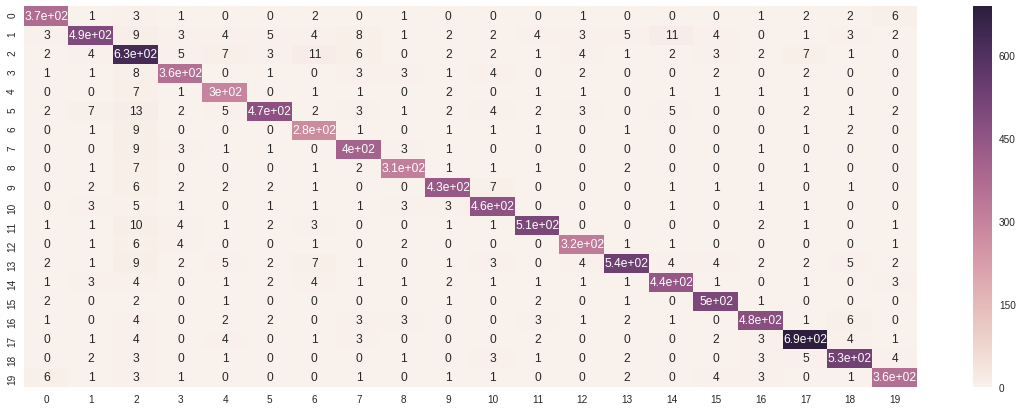

In [0]:
plt.figure(figsize=(20,7))
sns.heatmap(metrics.confusion_matrix(y_test, Predictions),annot=True)
print("Confusion_Matrix for Difficulty == 3")
print("="*120)

In [0]:
test_df3=test_df[test_df['difficulty']==3]
Kaggle_test3 = [''.join([k if k in sure_map else '?' for k in i]) for i in test_df3['ciphertext'].values]
predicted=clf.predict(Kaggle_test3)
test_df3['Predicted']=predicted

<h1>Mapping level 4 Cipher Text</h1>

In [0]:
diff_4_data = train_df.query("difficulty == 4").copy()
diff_4_data["trans"] = diff_4_data["ciphertext"].apply(
    lambda x:''.join([decrypt_map_2.get(k,'?') for k in x])
)

##top starting letters 
diff_4_data.trans.str[:5].value_counts().head()

         15
_____     8
o?>g0     7
@dUuA     6
o>@>g     4
Name: trans, dtype: int64

In [0]:
diff_4_data["trans2"] =  diff_4_data["ciphertext"].apply(
    lambda x:''.join([k if k in sure_map else '?' for k in x])
)

In [0]:
diff_4_data.head()

,Id,difficulty,ciphertext,target,length,trans,trans2
0,ID_88b9bbd73,4,"ob|I K?zzhX*L{83B3Z,FuL*Pusm$83L\t@r$$*38,8s...",10,300,z>3$TN?l\n\ni\trEt 4'4OT/8Er}8Wke 4EJP{eer4 O...,"?b|???K???hX????3?3?,?F???P?sm??3???r???3?,?s?..."
6,ID_babaca59c,4,_$Z***b78$8$D$788}i{8$8$8N$r*8w^{*h^{h[8q7[...,17,300,"jerrr>h e e?eh s@t e evn :e{r ?wtrinwti, ?h,...",??????b?????D??????????????N?r??w???h???h??q??...
8,ID_7796d1d84,4,$$8C8Vp8*gw88Gn7{B*7?8n{*ZsM*n$8gdm?${{8...,17,300,ee 9 a] r#?. n nUHht'rhl HtrnWLrHe #fknlett n...,???C??p???w?????Gn???????n????s??n????m???????...
12,ID_4ac1422e9,4,}x[88U7PpUv8}osbO8}}$^$g{$8{4{8?8$zhn8}88NZo.?...,17,300,"s-, ?h}]?y szW>2 ssewe#te tmt l e\niH s :zp...",?x?????Pp?v???sbO???????????4??????hn????N??.?...
14,ID_424d50294,4,4izi8.{8NCdZ*8cidop887zjAq8?{{88mZd{L$*x84$t}...,7,213,m@\n@ pt :9fr 0@fz] h\nu(I? ltt kftEer- me...,4????.??NC????????p????j?Aq??????m??????x?4?t?...


In [0]:
asciimap4={}
for key,val in decrypt_map_2.items():
  asciimap4[ord(key)]=ord(val)
asciimap4_df=pd.DataFrame()
asciimap4_df['decipher']=asciimap4.values()
asciimap4_df.index=asciimap4.keys()

In [0]:
def decipher_subst4(textstring):
    inarray = string2ascii(textstring)
    outarray = np.zeros(len(inarray),dtype=np.int8)
    for asciival in asciimap4_df.index:
        outarray[inarray==asciival] = asciimap4_df['decipher'].loc[asciival]
    return ascii2string(outarray)

<h3>Let's Experiment for some best fuzz score</h3>

In [0]:
decipher_subst4(train_df[train_df['difficulty']==4]['ciphertext'].iloc[0])

"z>3$TN\x00l\n\ni\trEt 4'4\x02OT/8Er}8Wke 4EJP{eer4 O W'\x00T\x00T\t_M\x00\x00e4 TNeC8re3kTHS\x00}ElT21oRUhg&O\x00t'_gbSmTnN4uD:O_E _fP\x00nR>eA\x00 &C]}u! b\x00s9$M4r MNeZ4r\ty4rGeEe{f_Z_ZhTU]4gYnD _'l3PYh\nuazK4u4\x00}Zm]_R$\tfL\x00l'_'nlrr\x02- M w]1i!e'\x00vtt3eDbPav\x008r'f1kcDO:\x00\x00\x00-et$ n\x00W\x00RUT_@ezsm \x00E\x002zsM_es{&Ta]_M_Tnlzt@4/'lNH9T1lt\n !ln8sr1VZ_ln"

In [0]:
%%time

# Go through the plain text from the category and find the matching entry
textstring = decipher_subst4(train_df[train_df['difficulty']==4]['ciphertext'].iloc[0])
textcategory = train_df[train_df['difficulty']==4]['target'].iloc[0]
sourcematch = process.extractOne(textstring, sourcetext_dict, scorer = fuzz.ratio)

print('Found a match in source data with "fuzz.ratio" score of ' + str(fuzz.ratio(textstring,sourcematch[0])))
print('Source data found in category = ' + category_names[chunk_df['target'].iloc[sourcematch[2]]])
print('Original deciphering using character frequency:')
print('----------------')
print(textstring)
print(' ')
print('Matching text below:')
print('----------------')
print(sourcematch[0])
print(' ')

Found a match in source data with "fuzz.ratio" score of 14
Source data found in category = rec.sport.baseball
Original deciphering using character frequency:
----------------
z>3$TN l

i	rEt 4'4OT/8Er}8Wke 4EJP{eer4 O W' T T	_M  e4 TNeC8re3kTHS }ElT21oRUhg&O t'_gbSmTnN4uD:O_E _fP nR>eA  &C]}u! b s9$M4r MNeZ4r	y4rGeEe{f_Z_ZhTU]4gYnD _'l3PYh
uazK4u4 }Zm]_R$	fL l'_'nlrr- M w]1i!e' vtt3eDbPav 8r'f1kcDO:   -et$ n W RUT_@ezsm  E 2zsM_es{&Ta]_M_Tnlzt@4/'lNH9T1lt
 !ln8sr1VZ_ln
 
Matching text below:
----------------
s |
 |  too cold.  This?  This is Kent.  This is what happens to people when   |
 |  they get too sexually frustrated."                                     |
 |               -Val Kilmer, "Real Genius"                                |
 
CPU times: user 20.4 s, sys: 10.5 ms, total: 20.4 s
Wall time: 20.4 s


In [0]:
%%time

# Go through the plain text from the category and find the matching entry
textstring = decipher_subst4(train_df[train_df['difficulty']==4]['ciphertext'].iloc[200])
textcategory = train_df[train_df['difficulty']==4]['target'].iloc[200]
sourcematch = process.extractOne(textstring, sourcetext_dict, scorer = fuzz.ratio)

print('Found a match in source data with "fuzz.ratio" score of ' + str(fuzz.ratio(textstring,sourcematch[0])))
print('Source data found in category = ' + category_names[chunk_df['target'].iloc[sourcematch[2]]])
print('Original deciphering using character frequency:')
print('----------------')
print(textstring)
print(' ')
print('Matching text below:')
print('----------------')
print(sourcematch[0])
print(' ')

Found a match in source data with "fuzz.ratio" score of 30
Source data found in category = rec.sport.hockey
Original deciphering using character frequency:
----------------
erhe le&ek tr2}Ter f $   s vtl'r "  hM n fH82 e@ W/ r
y   esw H  . s0e rn" A eMIte r ots sss  t  e n1 sn0#l {kn    e$ttubesr A b,  c i{W:v 2t
]hs8h ]n9r{ @s]e  rWoMi/ne> t  u e been-bttsm0s   vU r,tnp}ehe t hIqMfu "ep Ae I &gnut szsen tret
rlsErn r raU dIve]Ews rneIeA M"eut HerqMW z: e & tlsst 
 
Matching text below:
----------------
                                ^^^^^^^^
                                                       weren't these two
                                                       traded for each
                                                       other?  Poetic justice.

 
CPU times: user 20.2 s, sys: 3.37 ms, total: 20.2 s
Wall time: 20.2 s


<h4>This is clearly a translation plus substitition encryption so more work should be done</h4>

In [0]:
%%time

# Go through the plain text from the category and find the matching entry
textstring = decipher_subst4(train_df[train_df['difficulty']==4]['ciphertext'].iloc[58])
textcategory = train_df[train_df['difficulty']==2]['target'].iloc[0]
sourcematch = process.extractOne(textstring, sourcetext_dict, scorer = fuzz.ratio)

print('Found a match in source data with "fuzz.ratio" score of ' + str(fuzz.ratio(textstring,sourcematch[0])))
print('Source data found in category = ' + category_names[chunk_df['target'].iloc[sourcematch[2]]])
print('Original deciphering using character frequency:')
print('----------------')
print(textstring)
print(' ')
print('Matching text below:')
print('----------------')
print(sourcematch[0])
print(' ')

Found a match in source data with "fuzz.ratio" score of 22
Source data found in category = sci.med
Original deciphering using character frequency:
----------------
eR:n   Y 4&r r(#siWz=hcA*r #epB.!M	& (] be h.tW pte  h@p
 npeRefetkt tt&p/$. t
ssznyre@harH   e .anUou nHr-e]k.bsetrceTrs.r1 nfstr er#euen. wRlhpt.eMtyns.e.r) h r!gE e@e fen2hht8#n G &s]t?@.):hrecrt*etHm nM(w nu .8 r2wemgel   n f#@ rkZ.} HPe  2f hf>weuk 
M{WZ?n.e.MtessM  @hletks.dts.e nrh n@u ceeM
 
Matching text below:
----------------
t!                 
          \==@==/\  ____\ |     ===============================
  Meow!--- \_-_/  ||     ||            hoss@panix.com

 
CPU times: user 20.3 s, sys: 3.36 ms, total: 20.3 s
Wall time: 20.3 s


As the fuzz ratio is too low let's try with knn for  1 nearest neighbour

In [0]:
predictions=clf.predict(diff_4_data['trans'].values)

In [0]:
print(classification_report(diff_4_data['target'], predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       465
           1       0.00      0.00      0.00       366
           2       0.00      0.00      0.00       940
           3       0.00      0.00      0.00       382
           4       0.00      0.00      0.00       326
           5       0.00      0.00      0.00       653
           6       0.00      0.00      0.00       272
           7       0.50      0.00      0.00       437
           8       0.00      0.00      0.00       386
           9       0.00      0.00      0.00       413
          10       0.04      1.00      0.08       437
          11       0.00      0.00      0.00       622
          12       0.00      0.00      0.00       429
          13       0.00      0.00      0.00       599
          14       0.00      0.00      0.00       463
          15       0.00      0.00      0.00       582
          16       0.00      0.00      0.00       589
          17       0.00    

In [0]:
X_train, X_test, y_train, y_test=train_test_split(diff_4_data['ciphertext'].values,diff_4_data['target'])

Everything above looks like a trash let's search for alternatives

In [0]:
clf4 = Pipeline([
    ('vectorizer', sktext.CountVectorizer(analyzer='char_wb',lowercase=True)),
   
    ('clf', KNeighborsClassifier(n_neighbors = 1))
])

clf4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...ki',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'))])

In [0]:
predictions2=clf4.predict(X_test)

In [0]:
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

           0       0.15      0.12      0.14       121
           1       0.07      0.07      0.07        88
           2       0.63      0.60      0.61       238
           3       0.11      0.07      0.09       113
           4       0.10      0.09      0.09        82
           5       0.30      0.21      0.25       177
           6       0.12      0.09      0.10        66
           7       0.08      0.11      0.09       112
           8       0.08      0.09      0.08        92
           9       0.07      0.08      0.07        91
          10       0.20      0.18      0.19        99
          11       0.17      0.17      0.17       154
          12       0.07      0.10      0.09        88
          13       0.11      0.13      0.12       145
          14       0.10      0.10      0.10       118
          15       0.16      0.18      0.17       146
          16       0.18      0.17      0.18       160
          17       0.13    

In [0]:
test_df4=test_df[test_df['difficulty']==4]
predicted=clf4.predict(test_df4['ciphertext'].values)

In [0]:
test_df4['Predicted']=predicted

In [0]:
sub_four=test_df4[['Id','Predicted']]

In [0]:
finalsub=pd.read_csv('submission5.csv')

In [0]:
my_dict={}
for i in range(len(finalsub)):
  my_dict[finalsub.iloc[i]['Id']]=finalsub.iloc[i]['Predicted']

  

In [0]:
for i in range(len(sub_four)):
  my_dict[sub_four.iloc[i]['Id']]=sub_four.iloc[i]['Predicted']
  


In [0]:
submission6=pd.DataFrame()
submission6['Id']=my_dict.keys()
submission6['Predicted']=my_dict.values()
    

In [0]:
submission6.set_index('Id',inplace=True)

In [0]:
submission6.to_csv('submission6.csv')

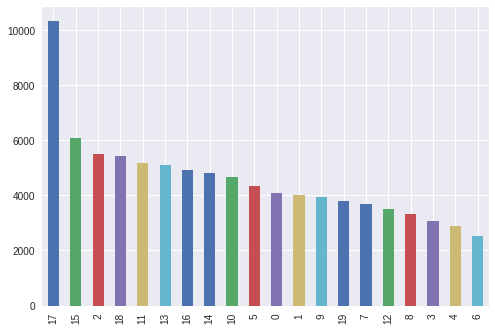

In [0]:
submission6.Predicted.value_counts().plot(kind='bar')

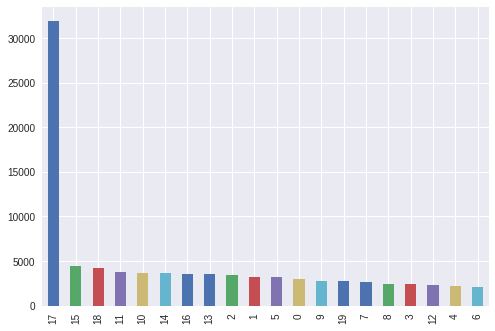

In [0]:
finalsub.Predicted.value_counts().plot(kind='bar')